In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import financial # from https://github.com/peliot/XIRR-and-XNPV
from matplotlib import style
pd.set_option('display.float_format', lambda x: '%.2f' % x)
style.use('ggplot')
% matplotlib inline

### Investment contions 

In [2]:
initial_inv = -10000.0
quarterly_contribution = -2500.0

### Quotes download: 

In [3]:
def quotes_df(ticker, start, end):
    '''
    Downloads quotes in csv and loads into pandas DataFrame
    ticker - 'APPL'
    start - 'YYYYMMDD'
    end - 'YYYYMMDD"
    '''
    url = "".join(("https://stooq.pl/q/d/l/?s=", ticker, "&d1=", start, "&d2=", end, "&i=d"))
    df = pd.read_csv(url)
    df = df[['Data','Zamkniecie']]
    df['Data'] = pd.to_datetime(df["Data"], format='%Y-%m-%d')
    df.set_index('Data', inplace=True)
    df.rename(columns={'Zamkniecie':'Price'}, inplace=True)
    return df

### Dollar Cost Averaging DataFrame creator:

In [4]:
def dca_df_creator(df, **quess_val):
    dca_df = df.asfreq(freq='Q',method='ffill')
    dca_df['DCA_contr'] = initial_inv
    dca_df.iloc[1:,1] = quarterly_contribution
    dca_df['DCA_cum_inv'] = dca_df['DCA_contr'].cumsum()
    dca_df['DCA_shares_bought'] = -dca_df['DCA_contr']/dca_df.iloc[:,0]
    dca_df['DCA_cum_shares'] = dca_df['DCA_shares_bought'].cumsum()
    dca_df['DCA_Total_Val'] = dca_df['DCA_cum_shares'] * dca_df.iloc[:,0]
    dca_df['DCA_avg_price'] = -dca_df['DCA_cum_inv'] / dca_df['DCA_cum_shares']
    dca_df['DCA_P&L'] = dca_df['DCA_Total_Val'] + dca_df['DCA_cum_inv']
    values = list(dca_df['DCA_contr'])
    values.append(dca_df['DCA_Total_Val'][-1])
    dates = list(dca_df.index)
    dates.append(dca_df.index[-1])
    feed = []
    for date, val in zip(dates, values):
        feed.append((date, val))
    dca_xirr = financial.xirr(tuple(feed), guess=quess_val.get('guess_val',0.1))
    return dca_df, dca_xirr

### Value Averaging DataFrame creator:

In [5]:
def va_df_creator(df, **quess_val):   
    va_df = df.asfreq(freq='Q',method='ffill')
    va_df['VA_target'] = initial_inv
    va_df.iloc[1:,1] = quarterly_contribution
    va_df['VA_target_cum'] = va_df['VA_target'].cumsum()
    va_df['VA_target_shares'] = -va_df['VA_target']/va_df.iloc[:,0]

    va_df.loc[va_df.index[0],'VA_contr'] = initial_inv
    va_df.loc[va_df.index[0],'VA_shares_bought'] = -initial_inv/va_df.iloc[:,0][0]
    va_df.loc[va_df.index[0],'VA_cum_shares'] = va_df['VA_shares_bought'][0]

    n = 0
    for i, row in va_df.iterrows():
        cur_target = va_df['VA_target_cum'][i]
        prev_cum = va_df['VA_cum_shares'][n-1]
        cur_price = va_df.iloc[:,0][i]
        n += 1
        if i == va_df.index[0]:
            continue
        else:
            cur_cont = cur_target + (prev_cum * cur_price)
            cur_shares = -cur_cont / cur_price
            va_df.loc[i,'VA_contr'] = cur_cont
            va_df.loc[i, 'VA_shares_bought'] = cur_shares
            va_df.loc[i, 'VA_cum_shares'] = prev_cum + cur_shares

    va_df['VA_cum_inv'] = va_df['VA_contr'].cumsum()
    va_df['VA_Total_Val'] = va_df['VA_cum_shares'] * va_df.iloc[:,0]
    va_df['VA_avg_price'] = -va_df['VA_cum_inv'] / va_df['VA_cum_shares']
    va_df['VA_P&L'] = va_df['VA_Total_Val'] + va_df['VA_cum_inv']
    values = list(va_df['VA_contr'])
    values.append(va_df['VA_Total_Val'][-1])
    dates = list(va_df.index)
    dates.append(va_df.index[-1])
    feed = []
    for date, val in zip(dates, values):
        feed.append((date, val))
    va_xirr = financial.xirr(tuple(feed), guess=quess_val.get('guess_val',0.1))
    va_df = va_df[['Price', 'VA_contr', 'VA_cum_inv', 'VA_shares_bought','VA_cum_shares',
                   'VA_Total_Val', 'VA_avg_price', 'VA_P&L']]
    return va_df, va_xirr

### Comparison graphs creator:

In [6]:
def comparison_graphs(df_dca, df_va):
    return_df = pd.concat([df_dca[['DCA_cum_inv','DCA_P&L']], df_va[['VA_cum_inv','VA_P&L']]], axis=1)
    return_df['DCA_return'] = return_df['DCA_P&L'] / -return_df['DCA_cum_inv']*100
    return_df['VA_return'] = return_df['VA_P&L'] / -return_df['VA_cum_inv']*100
    return_df['diff'] = return_df['VA_return'] - return_df['DCA_return']

    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,10))
    ax1.plot(return_df.index, return_df['VA_return'], linewidth=3, label='Value Averaging', color='b')
    ax1.plot(return_df.index, return_df['DCA_return'], linewidth=3, label='Dollar Cost Averaging', color='r')
    ax1.legend(loc='best')
    ax1.set_title('DCA and VA investment returns (%)')
    ax1.set_ylabel('Investment return (%)')
    ax2.fill_between(return_df.index, y1=return_df['diff'], y2=0, color='b', where=return_df['diff']>0)
    ax2.fill_between(return_df.index, y1=return_df['diff'], y2=0, color='r', where=return_df['diff']<0)
    ax2.set_ylabel('Difference in return pp')
    ax2.set_title('Difference (Value Averaging return % - Dollar Cost Average return % )')
    ax2.legend(["Value Averaging outperformance", "Dollar Cost Averaging outperformance"], loc='upper left');
    return return_df.tail()

# Study 1: Bull Market (S&P 500)

### Stock performance visualisation 

In [7]:
bull_df = quotes_df('^SPX', '20120101', '20180101')

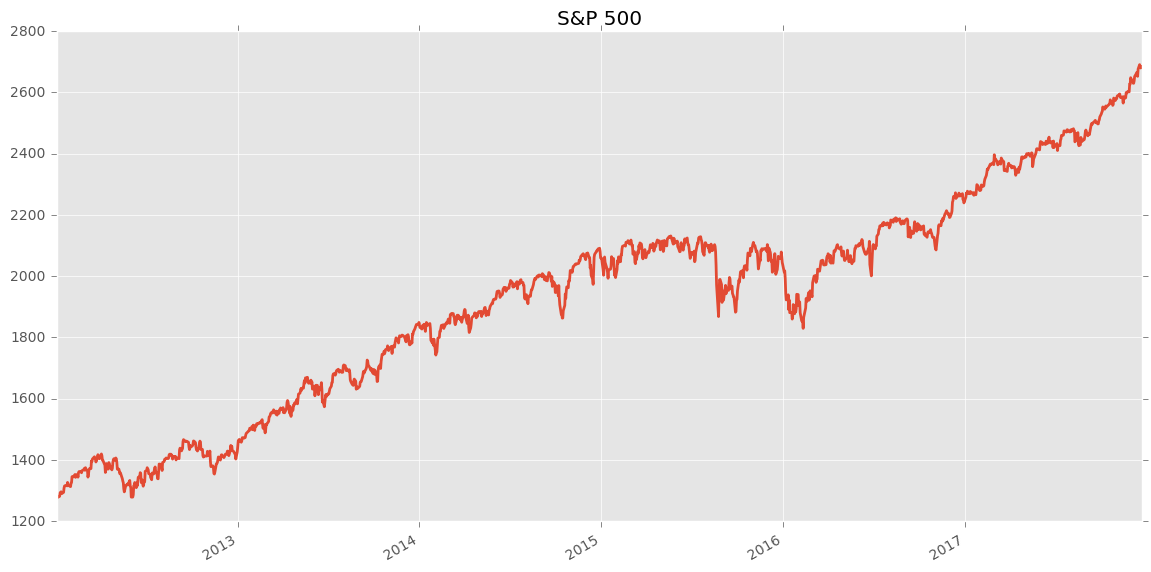

In [8]:
ax = bull_df.plot(figsize=(14,7), linewidth=2, legend=False, title = 'S&P 500')
plt.xlabel('');

### Dollar Cost Averaging DataFrame:

In [9]:
bull_dca, bull_dca_xirr = dca_df_creator(bull_df)
bull_dca

,Price,DCA_contr,DCA_cum_inv,DCA_shares_bought,DCA_cum_shares,DCA_Total_Val,DCA_avg_price,DCA_P&L
Data,,,,,,,,
2012-03-31,1408.47,-10000.00,-10000.00,7.10,7.10,10000.00,1408.47,0.00
2012-06-30,1362.16,-2500.00,-12500.00,1.84,8.94,12171.20,1398.96,-328.80
2012-09-30,1440.67,-2500.00,-15000.00,1.74,10.67,15372.71,1405.74,372.71
2012-12-31,1426.19,-2500.00,-17500.00,1.75,12.42,17718.20,1408.63,218.20
2013-03-31,1569.19,-2500.00,-20000.00,1.59,14.02,21994.75,1426.88,1994.75
2013-06-30,1606.28,-2500.00,-22500.00,1.56,15.57,25014.63,1444.81,2514.63
2013-09-30,1681.55,-2500.00,-25000.00,1.49,17.06,28686.81,1465.44,3686.81
2013-12-31,1848.36,-2500.00,-27500.00,1.35,18.41,34032.55,1493.57,6532.55
2014-03-31,1872.34,-2500.00,-30000.00,1.34,19.75,36974.07,1519.18,6974.07


### Value Averaging DataFrame

In [10]:
bull_va, bull_va_xirr = va_df_creator(bull_df)
bull_va

,Price,VA_contr,VA_cum_inv,VA_shares_bought,VA_cum_shares,VA_Total_Val,VA_avg_price,VA_P&L
Data,,,,,,,,
2012-03-31,1408.47,-10000.00,-10000.00,7.10,7.10,10000.00,1408.47,0.00
2012-06-30,1362.16,-2828.80,-12828.80,2.08,9.18,12500.00,1397.99,-328.80
2012-09-30,1440.67,-1779.54,-14608.34,1.24,10.41,15000.00,1403.05,391.66
2012-12-31,1426.19,-2650.76,-17259.10,1.86,12.27,17500.00,1406.56,240.90
2013-03-31,1569.19,-745.32,-18004.43,0.47,12.75,20000.00,1412.62,1995.57
2013-06-30,1606.28,-2027.27,-20031.70,1.26,14.01,22500.00,1430.07,2468.30
2013-09-30,1681.55,-1445.65,-21477.36,0.86,14.87,25000.00,1444.61,3522.64
2013-12-31,1848.36,-20.00,-21497.35,0.01,14.88,27500.00,1444.90,6002.65
2014-03-31,1872.34,-2143.22,-23640.58,1.14,16.02,30000.00,1475.44,6359.42


### Bull market results comparison

,DCA_cum_inv,DCA_P&L,VA_cum_inv,VA_P&L,DCA_return,VA_return,diff
Data,,,,,,,
2016-09-30,-55000.00,14402.98,-42414.48,12585.52,26.19,29.67,3.49
2016-12-31,-57500.00,16661.50,-43124.66,14375.34,28.98,33.33,4.36
2017-03-31,-60000.00,20765.37,-42442.79,17557.21,34.61,41.37,6.76
2017-06-30,-62500.00,22839.95,-43401.60,19098.40,36.54,44.00,7.46
2017-09-30,-65000.00,26218.81,-43427.04,21572.96,40.34,49.68,9.34


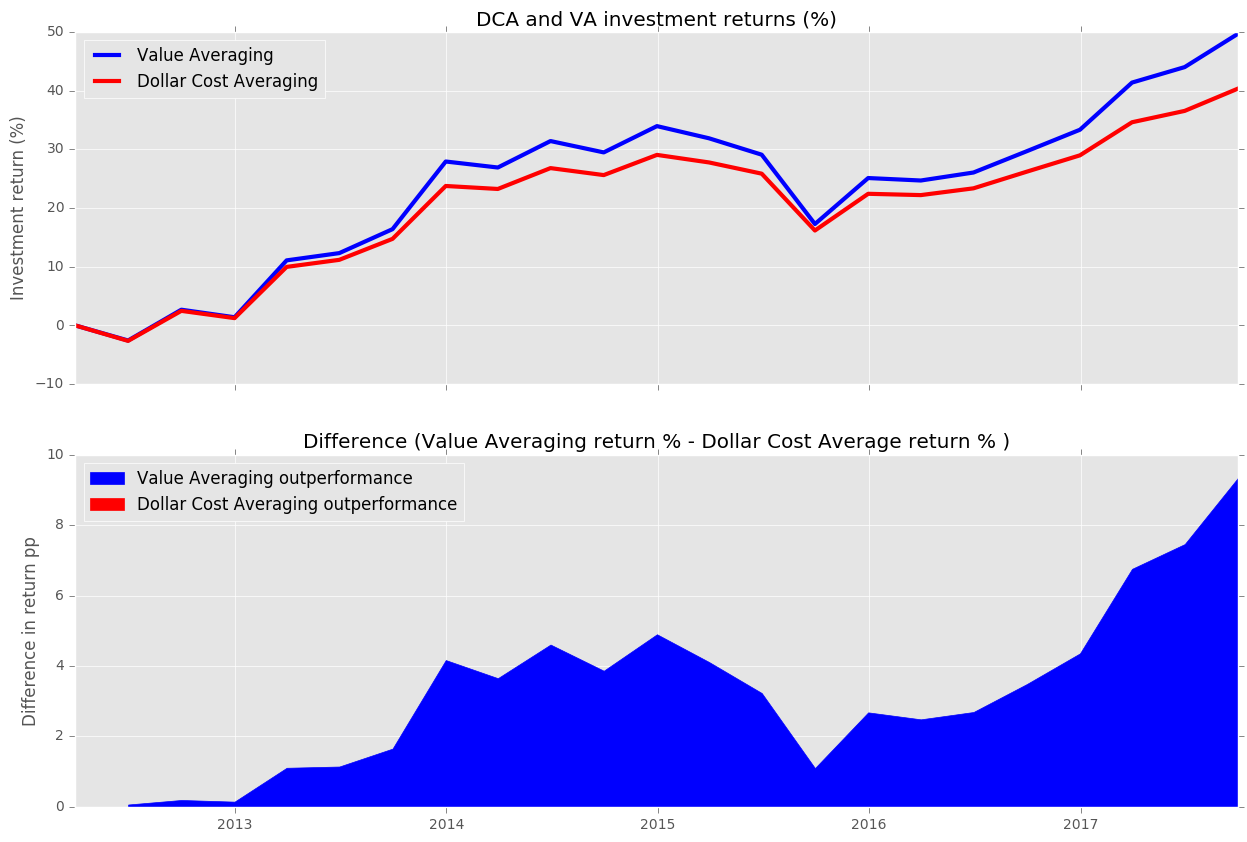

In [11]:
comparison_graphs(bull_dca, bull_va)

In [12]:
summary = [['Final Value', bull_dca['DCA_Total_Val'][-1], bull_va['VA_Total_Val'][-1]],
          ['Tolat Invested', -bull_dca['DCA_cum_inv'][-1], -bull_va['VA_cum_inv'][-1]],
          ['Profit / Loss', bull_dca['DCA_P&L'][-1], bull_va['VA_P&L'][-1]],
          ['Avg share price', bull_dca['DCA_avg_price'][-1], bull_va['VA_avg_price'][-1]],
          ['XIRR', bull_dca_xirr*100, bull_va_xirr*100]]

bull_summary = pd.DataFrame(summary, columns=['Measure', 'DCA_bull', 'VA_bull'])
bull_summary = bull_summary.set_index('Measure')
bull_summary

,DCA_bull,VA_bull
Measure,,
Final Value,91218.81,65000.00
Tolat Invested,65000.00,43427.04
Profit / Loss,26218.81,21572.96
Avg share price,1795.23,1683.21
XIRR,11.04,11.29


# Study 2: Bear Market (Deutsche Bank)

### Stock performance visualisation 

In [13]:
bear_df = quotes_df('DB.US', '20120101', '20180101')

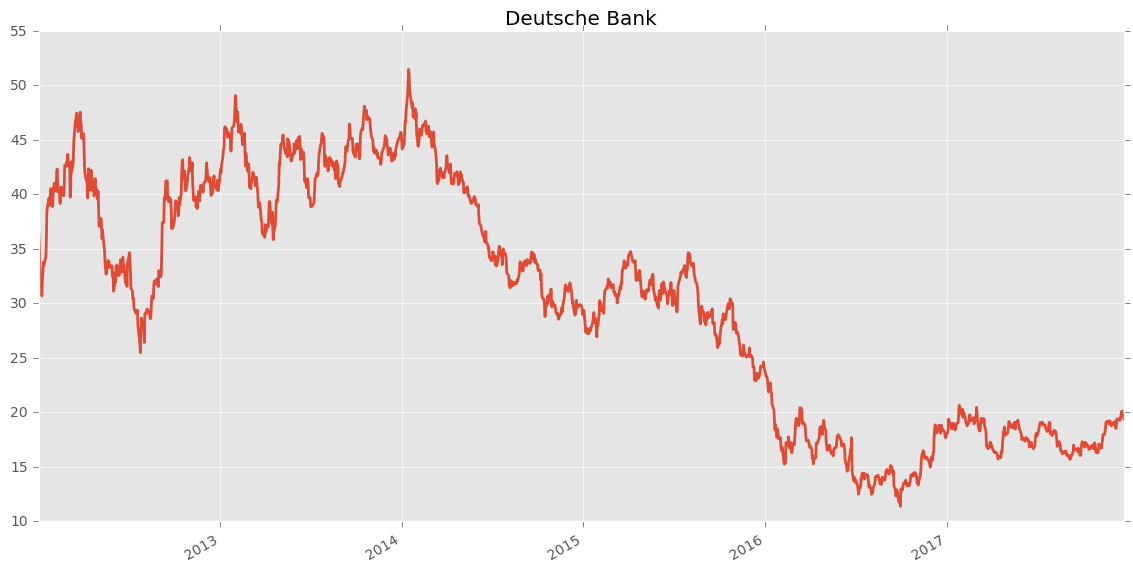

In [14]:
ax = bear_df.plot(figsize=(14,7), linewidth=2, legend=False, title = 'Deutsche Bank')
plt.xlabel('');

### Dollar Cost Averaging DataFrame:

In [15]:
bear_dca, bear_dca_xirr = dca_df_creator(bear_df, guess_val=-0.5)
bear_dca

,Price,DCA_contr,DCA_cum_inv,DCA_shares_bought,DCA_cum_shares,DCA_Total_Val,DCA_avg_price,DCA_P&L
Data,,,,,,,,
2012-03-31,45.39,-10000.00,-10000.00,220.30,220.30,10000.00,45.39,0.00
2012-06-30,33.68,-2500.00,-12500.00,74.23,294.53,9919.43,42.44,-2580.57
2012-09-30,36.92,-2500.00,-15000.00,67.72,362.24,13373.70,41.41,-1626.30
2012-12-31,41.24,-2500.00,-17500.00,60.62,422.87,17438.96,41.38,-61.04
2013-03-31,36.42,-2500.00,-20000.00,68.63,491.50,17902.86,40.69,-2097.14
2013-06-30,39.70,-2500.00,-22500.00,62.97,554.47,22012.03,40.58,-487.97
2013-09-30,43.42,-2500.00,-25000.00,57.58,612.05,26573.56,40.85,1573.56
2013-12-31,45.65,-2500.00,-27500.00,54.76,666.82,30440.89,41.24,2940.89
2014-03-31,42.42,-2500.00,-30000.00,58.93,725.75,30789.07,41.34,789.07


### Value Averaging DataFrame

In [16]:
bear_va, bear_va_xirr = va_df_creator(bear_df, guess_val=-0.5)
bear_va

,Price,VA_contr,VA_cum_inv,VA_shares_bought,VA_cum_shares,VA_Total_Val,VA_avg_price,VA_P&L
Data,,,,,,,,
2012-03-31,45.39,-10000.00,-10000.00,220.30,220.30,10000.00,45.39,0.00
2012-06-30,33.68,-5080.57,-15080.57,150.85,371.15,12500.00,40.63,-2580.57
2012-09-30,36.92,-1297.47,-16378.04,35.14,406.29,15000.00,40.31,-1378.04
2012-12-31,41.24,-744.40,-17122.44,18.05,424.35,17500.00,40.35,377.56
2013-03-31,36.42,-4543.22,-21665.67,124.73,549.07,20000.00,39.46,-1665.67
2013-06-30,39.70,-702.33,-22368.00,17.69,566.76,22500.00,39.47,132.00
2013-09-30,43.42,-392.77,-22760.77,9.05,575.81,25000.00,39.53,2239.23
2013-12-31,45.65,-1213.64,-23974.41,26.59,602.40,27500.00,39.80,3525.59
2014-03-31,42.42,-4443.93,-28418.34,104.75,707.15,30000.00,40.19,1581.66


### Bear market results comparison

,DCA_cum_inv,DCA_P&L,VA_cum_inv,VA_P&L,DCA_return,VA_return,diff
Data,,,,,,,
2016-09-30,-55000.00,-31128.33,-98361.50,-43361.50,-56.60,-44.08,12.51
2016-12-31,-57500.00,-21991.88,-79811.22,-22311.22,-38.25,-27.95,10.29
2017-03-31,-60000.00,-23836.20,-85297.82,-25297.82,-39.73,-29.66,10.07
2017-06-30,-62500.00,-22099.91,-84917.11,-22417.11,-35.36,-26.40,8.96
2017-09-30,-65000.00,-23258.09,-89208.85,-24208.85,-35.78,-27.14,8.64


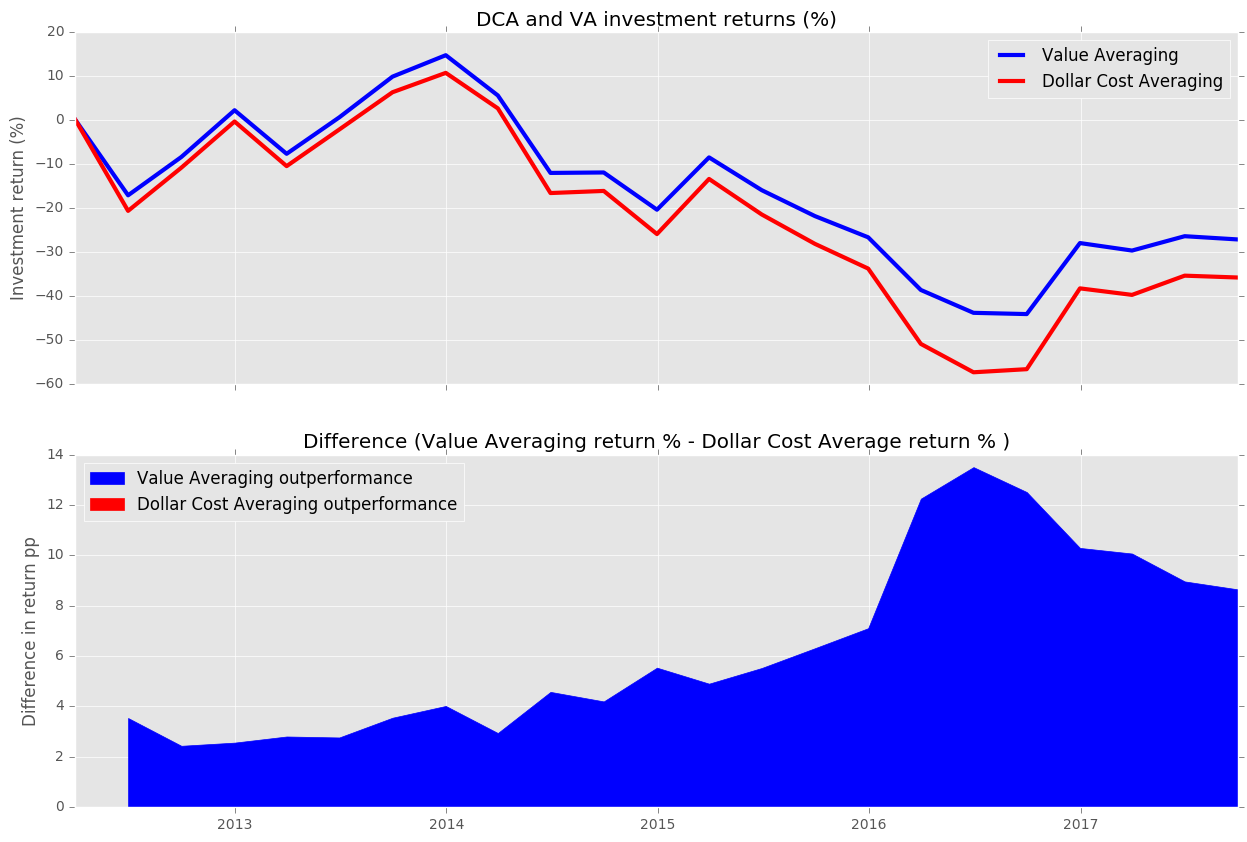

In [17]:
comparison_graphs(bear_dca, bear_va)

In [18]:
summary = [['Final Value', bear_dca['DCA_Total_Val'][-1], bear_va['VA_Total_Val'][-1]],
          ['Tolat Invested', -bear_dca['DCA_cum_inv'][-1], -bear_va['VA_cum_inv'][-1]],
          ['Profit / Loss', bear_dca['DCA_P&L'][-1], bear_va['VA_P&L'][-1]],
          ['Avg share price', bear_dca['DCA_avg_price'][-1], bear_va['VA_avg_price'][-1]],
          ['XIRR', bear_dca_xirr*100, bear_va_xirr*100]]

bear_summary = pd.DataFrame(summary, columns=['Measure', 'DCA_bear', 'VA_bear'])
bear_summary = bear_summary.set_index('Measure')
bear_summary

,DCA_bear,VA_bear
Measure,,
Final Value,41741.91,65000.00
Tolat Invested,65000.00,89208.85
Profit / Loss,-23258.09,-24208.85
Avg share price,26.91,23.72
XIRR,-14.55,-10.70


# Study 3: Consolidation

### Stock performance visualisation 

In [19]:
consol_df = quotes_df('GOLD.US', '20120101', '20180101')

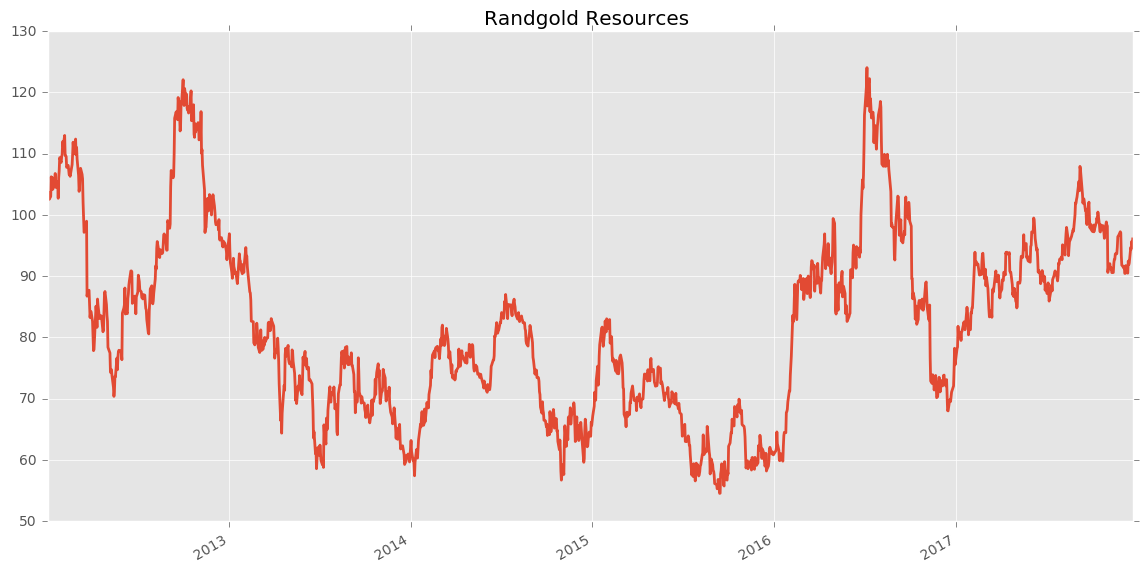

In [20]:
ax = consol_df.plot(figsize=(14,7), linewidth=2, legend=False, title = 'Randgold Resources ')
plt.xlabel('');

### Dollar Cost Averaging DataFrame:

In [21]:
consol_dca, consol_dca_xirr = dca_df_creator(consol_df, guess_val=-0.5)
consol_dca

,Price,DCA_contr,DCA_cum_inv,DCA_shares_bought,DCA_cum_shares,DCA_Total_Val,DCA_avg_price,DCA_P&L
Data,,,,,,,,
2012-03-31,84.20,-10000.00,-10000.00,118.77,118.77,10000.00,84.20,0.00
2012-06-30,86.59,-2500.00,-12500.00,28.87,147.64,12783.61,84.67,283.61
2012-09-30,118.32,-2500.00,-15000.00,21.13,168.77,19968.64,88.88,4968.64
2012-12-31,95.44,-2500.00,-17500.00,26.20,194.96,18606.89,89.76,1106.89
2013-03-31,82.71,-2500.00,-20000.00,30.23,225.19,18625.20,88.81,-1374.80
2013-06-30,61.95,-2500.00,-22500.00,40.36,265.55,16449.82,84.73,-6050.18
2013-09-30,69.24,-2500.00,-25000.00,36.11,301.66,20885.39,82.88,-4114.61
2013-12-31,60.80,-2500.00,-27500.00,41.12,342.78,20839.12,80.23,-6660.88
2014-03-31,73.02,-2500.00,-30000.00,34.24,377.01,27530.94,79.57,-2469.06


### Value Averaging DataFrame

In [22]:
consol_va, consol_va_xirr = va_df_creator(consol_df, guess_val=-0.5)
consol_va

,Price,VA_contr,VA_cum_inv,VA_shares_bought,VA_cum_shares,VA_Total_Val,VA_avg_price,VA_P&L
Data,,,,,,,,
2012-03-31,84.20,-10000.00,-10000.00,118.77,118.77,10000.00,84.20,0.00
2012-06-30,86.59,-2216.39,-12216.39,25.60,144.36,12500.00,84.62,283.61
2012-09-30,118.32,2081.09,-10135.30,-17.59,126.77,15000.00,79.95,4864.70
2012-12-31,95.44,-5400.86,-15536.16,56.59,183.37,17500.00,84.73,1963.84
2013-03-31,82.71,-4834.05,-20370.22,58.45,241.81,20000.00,84.24,-370.22
2013-06-30,61.95,-7520.49,-27890.71,121.40,363.21,22500.00,76.79,-5390.71
2013-09-30,69.24,147.46,-27743.25,-2.13,361.08,25000.00,76.83,-2743.25
2013-12-31,60.80,-5547.91,-33291.15,91.26,452.34,27500.00,73.60,-5791.15
2014-03-31,73.02,3031.66,-30259.49,-41.52,410.82,30000.00,73.66,-259.49


### Consolidation market results comparison

,DCA_cum_inv,DCA_P&L,VA_cum_inv,VA_P&L,DCA_return,VA_return,diff
Data,,,,,,,
2016-09-30,-55000.00,16062.65,-32122.60,22877.40,29.20,71.22,42.01
2016-12-31,-57500.00,-789.05,-47665.22,9834.78,-1.37,20.63,22.01
2017-03-31,-60000.00,8066.31,-41186.65,18813.35,13.44,45.68,32.23
2017-06-30,-62500.00,8986.55,-42875.47,19624.53,14.38,45.77,31.39
2017-09-30,-65000.00,16421.28,-38875.36,26124.64,25.26,67.20,41.94


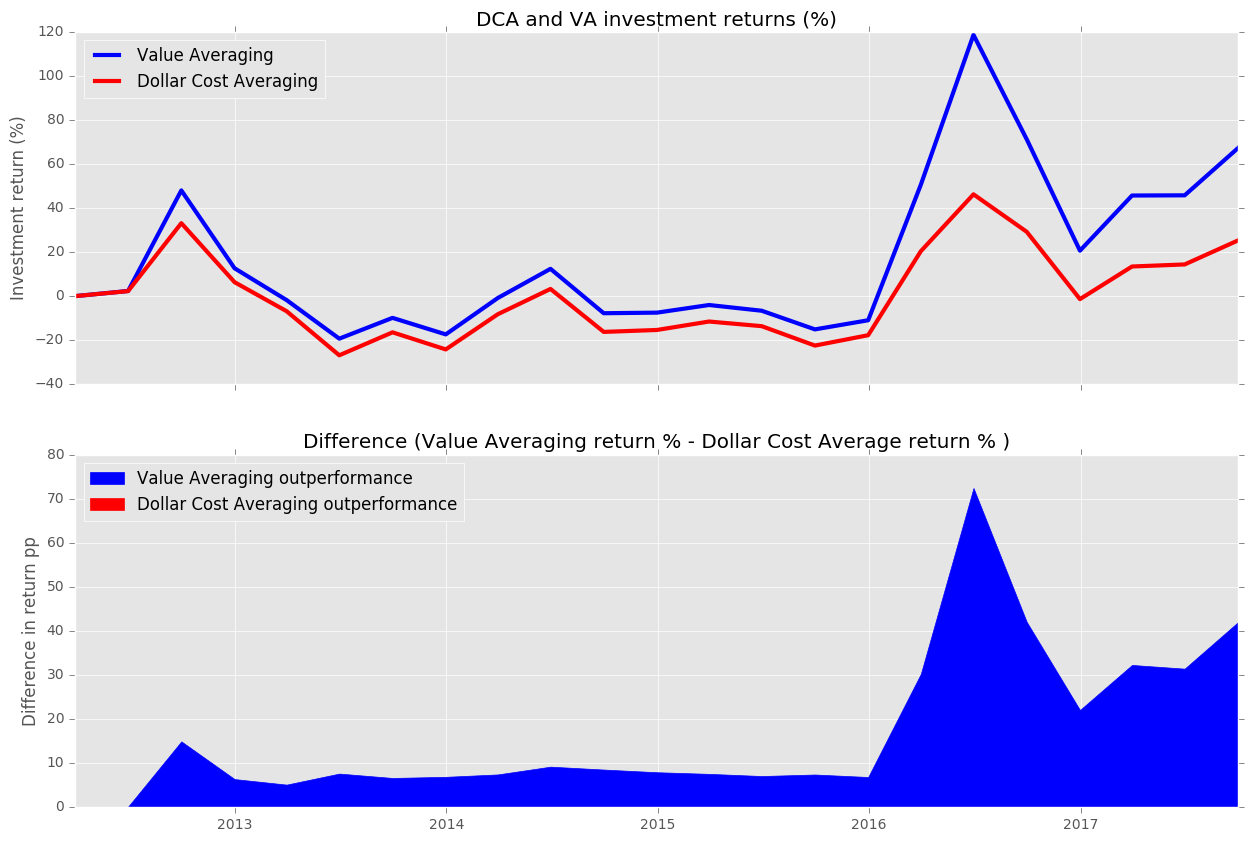

In [23]:
comparison_graphs(consol_dca, consol_va)

In [24]:
summary = [['Final Value', consol_dca['DCA_Total_Val'][-1], consol_va['VA_Total_Val'][-1]],
          ['Tolat Invested', -consol_dca['DCA_cum_inv'][-1], -consol_va['VA_cum_inv'][-1]],
          ['Profit / Loss', consol_dca['DCA_P&L'][-1], consol_va['VA_P&L'][-1]],
          ['Avg share price', consol_dca['DCA_avg_price'][-1], consol_va['VA_avg_price'][-1]],
          ['XIRR', consol_dca_xirr*100, consol_va_xirr*100]]

consolidation_summary = pd.DataFrame(summary, columns=['Measure', 'DCA_consol', 'VA_consol'])
consolidation_summary = consolidation_summary.set_index('Measure')
consolidation_summary

,DCA_consol,VA_consol
Measure,,
Final Value,81421.28,65000.00
Tolat Invested,65000.00,38875.36
Profit / Loss,16421.28,26124.64
Avg share price,77.96,58.41
XIRR,7.33,11.92


# Three scenarios summary

In [25]:
final_summary = pd.concat([bull_summary, bear_summary, consolidation_summary], axis=1)
final_summary

,DCA_bull,VA_bull,DCA_bear,VA_bear,DCA_consol,VA_consol
Measure,,,,,,
Final Value,91218.81,65000.00,41741.91,65000.00,81421.28,65000.00
Tolat Invested,65000.00,43427.04,65000.00,89208.85,65000.00,38875.36
Profit / Loss,26218.81,21572.96,-23258.09,-24208.85,16421.28,26124.64
Avg share price,1795.23,1683.21,26.91,23.72,77.96,58.41
XIRR,11.04,11.29,-14.55,-10.70,7.33,11.92
